In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Load the NetCDF file
ds = xr.open_dataset("results/2025-07-11T00Z/pred_2025-07-11T00Z_006.nc")
print(f"{'-'*60}Metadata{'-'*60}")
print(ds)
print(f"\n\n{'-'*60}Variables{'-'*60}")
print(ds.variables.keys())   # List of all variables
print(f"\n\n{'-'*60}Coordinates{'-'*60}")
print(ds.coords)           # Check all coordinates

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Matplotlib is building the font cache; this may take a moment.


FileNotFoundError: [Errno 2] No such file or directory: '/Users/isaacob/Documents/Project/mesonet-siparcs25/cloud/services/credit/credit_run/results/2025-07-11T00Z/pred_2025-07-11T00Z_006.nc'

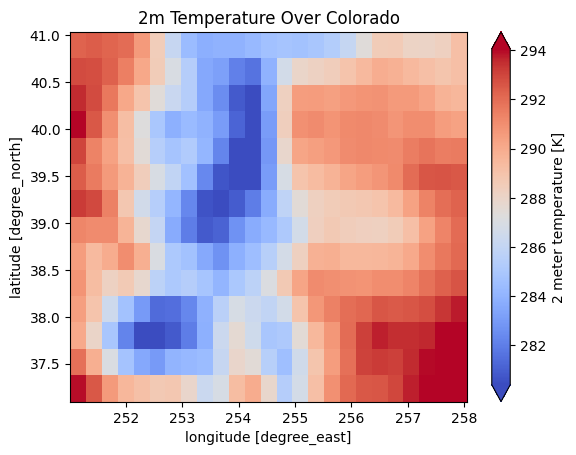

In [2]:
# --- Define Colorado Bounding Box (lat: 37-41N, lon: 251-258E for 109W to 102W) ---
colorado_ds = ds.sel(
    latitude=slice(41.0, 37.0),  # Must be north to south
    longitude=slice(251.0, 258.0)  # 360 - 109 = 251, 360 - 102 = 258
)

# --- (Optional) Plot a snapshot (e.g., 2-meter temperature) ---
if 't2m' in colorado_ds:
    colorado_ds['t2m'].isel(time=0).plot(
        cmap='coolwarm',
        robust=True
    )
    plt.title("2m Temperature Over Colorado")
    plt.show()

In [3]:
# --- Interpolate model data to specific MPD station location ---
# Let's assume MPD station is in Denver: lat = 39.7392, lon = -104.9903 (=> 255.0097E)
mpd_lat = 39.7392
mpd_lon = (360 - 104.9903)  # Convert to 0–360

ds_axes = {
    'latitude': np.array([mpd_lat]),
    'longitude': np.array([mpd_lon])
}

# Interpolate variables (e.g., T_HEIGHT and Q_HEIGHT)
temp_credit = ds['T_HEIGHT'].interp(**ds_axes).values.squeeze()
wv_credit = ds['Q_HEIGHT'].interp(**ds_axes).values.squeeze() * 1e3  # g/kg

print("Interpolated Temperature Profile (K):", temp_credit)
print("Interpolated Water Vapor Profile (g/kg):", wv_credit)

Interpolated Temperature Profile (K): [292.66617368 292.9124614  290.42807577 282.55911001 275.495397
 266.88484512 260.13867251 254.31383554]
Interpolated Water Vapor Profile (g/kg): [7.52054474 6.50404299 6.02349676 4.34838141 3.26360521 2.95733108
 1.48015173 0.68395081]


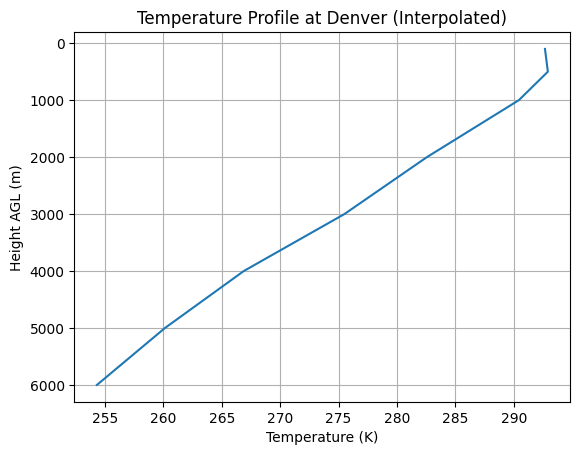

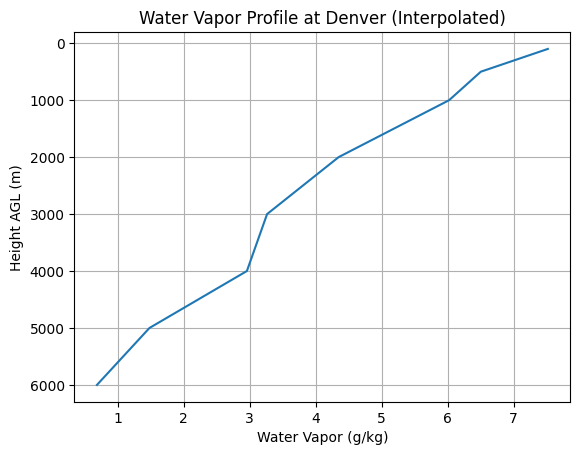

In [4]:
# Extract height levels
heights = ds['height_agl'].values

# Plot temperature
plt.figure()
plt.plot(temp_credit, heights)
plt.gca().invert_yaxis()
plt.xlabel("Temperature (K)")
plt.ylabel("Height AGL (m)")
plt.title("Temperature Profile at Denver (Interpolated)")
plt.grid(True)
plt.show()

# Plot water vapor
plt.figure()
plt.plot(wv_credit, heights)
plt.gca().invert_yaxis()
plt.xlabel("Water Vapor (g/kg)")
plt.ylabel("Height AGL (m)")
plt.title("Water Vapor Profile at Denver (Interpolated)")
plt.grid(True)
plt.show()

In [5]:
# --- (Optional) Save Colorado subset to new NetCDF ---
colorado_ds.to_netcdf("pro_data/colorado_subset.nc")
print("Saved: pro_data/colorado_subset.nc")

Saved: pro_data/colorado_subset.nc


In [6]:
# --- Choose a variable to export (e.g., t2m or T_HEIGHT at a given height) ---
# Example 1: 2-meter temperature (no vertical level)
t2m_data = colorado_ds['t2m'].isel(time=0)  # Shape: (lat, lon)

# Convert to DataFrame
df = t2m_data.to_dataframe().reset_index()

# Save to Excel
df.to_excel("pro_data/colorado_t2m.xlsx", index=False)
print("Saved: pro_data/colorado_t2m.xlsx")

Saved: pro_data/colorado_t2m.xlsx


In [7]:
# --- Example 2: 3D variable (e.g., T_HEIGHT at 500m AGL) ---
if 'T_HEIGHT' in colorado_ds:
    t_height_data = colorado_ds['T_HEIGHT'] \
        .sel(height_agl=500, method='nearest') \
        .isel(time=0)
    df_height = t_height_data.to_dataframe().reset_index()
    df_height.to_excel("pro_data/colorado_T_HEIGHT_500m.xlsx", index=False)
    print("Saved: pro_data/colorado_T_HEIGHT_500m.xlsx")

Saved: pro_data/colorado_T_HEIGHT_500m.xlsx


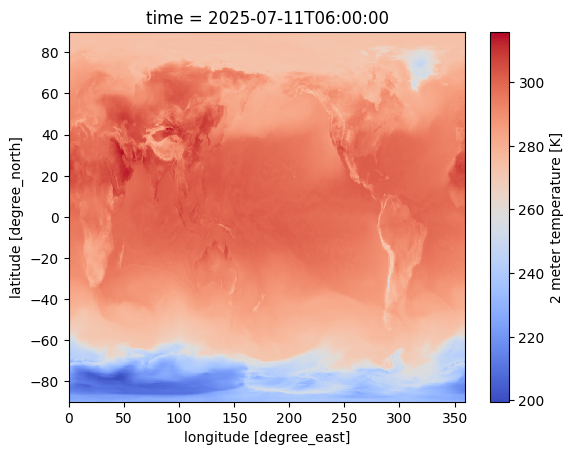

In [8]:
t2m_data = ds['t2m'].isel(time=0)
t2m_data.plot(cmap='coolwarm')